# Ephemeris object imaging: JVLA continuum (mosaic gridder) TRACKFIELD - Callisto 

This nootebook demonstlates continuum imaging of the ephemeris objects. 
In the following steps first we use the attached ephemeris table(s) 

In [1]:
# extra packages needed
#import os
#os.system('pip install astropy')
#os.system('pip install aplpy')

In [2]:
# import helper functions defined in 'Trackfield' mfs mosaic notebook
from ipynb.fs.defs.ephemimagingVenusMfsMosaicTrackfield import *

In [3]:
from casatasks import getephemtable, tclean, exportfits, listobs, clearstat
from casatools import measures, quanta, table, image, msmetadata
import os
from astropy.io import fits
from matplotlib import pyplot
import pylab as pl
import aplpy
import shutil
me = measures()
qa = quanta()
tb = table()
ia = image()
msmd = msmetadata()

Define some useful funcitons
delete_tcleanimages: delete previous images from tclean run
get_attachedEphemtablepath: returns full eph table path for the corresponding field id

In [4]:
# import functions defined in trackfield notebook
#%run ephemimaging-venus-mfs-mosaic-trackfield.ipynb

In [5]:
#def delete_tcleanimages(imagename):
#    ''' clean up images from a previous run '''
#    imtypes = ['residual', 'image', 'psf', 'pb', 'model', 'sumwt','mask']
#    for type in imtypes:
#        if os.path.exists(f'{imagename}.{type}'):
#            os.system(f'rm -rf {imagename}.{type}')

In [6]:
#def get_attachedEphemtablepath(msfile, fieldid):
#    ''' returns full path of attached eph table for a specified field ID'''
#    import glob
#    tb.open(msfile+'/FIELD')
#    ephemid = tb.getcell('EPHEMERIS_ID',fieldid)
#    tb.close()
#    tabname = glob.glob(f'{msfile}/FIELD/EPHEM{ephemid}*/')
#    return os.path.abspath(tabname[0])

# 1) Imaging with epehemeris data attached to the MS, a shortcut 'TRACKFIELD' is used
In order to track the ephemeris source during the observations, the proper ephemeris data is used. 
Ususally such ephemeris data table(s) are attached to the Measurement Set automatically during importadm when they are available. This demo shows use of 'TRACKFIELD' in phaseceter to short cut explicit specification of the internal ephemeris table.

In [7]:
datapath='/stash/users/ttsutsum/casadev/imagingissues/ephemimaging/vladata/'
# Use local data directory
#datapath='/Volumes/ssd1/casatestdata/measurementset/alma/'
#datapath='/Users/ttsutsum/SWDevel/ephemdemo/notebooks/'

In [8]:
msfile='callisto_ka_leading_polcal_averagespw.ms'
if os.path.exists(msfile):
    shutil.rmtree(msfile)
os.system(f'cp -r {datapath}{msfile} {msfile}')

0

In [9]:
imgname='mosaic-mfs-trackfield-callisto-vla'

In [10]:
delete_tcleanimages(imgname)

In [11]:
ret=tclean(vis=msfile, field='Callisto', imagename=imgname, imsize=[1080,1080], cell=['0.07arcsec'], 
           phasecenter='TRACKFIELD', specmode='mfs', gridder='mosaic', usepointing=True, niter=100)
ret['iterdone']


0%....10....20....30....40....50....60....70....80....90....100%
2024-04-19 16:32:57	WARN	tclean::::casa	Warning! Non-zero values at the edge of the .pb image can cause unexpected aliasing effects! (found value 0.5422337055206299 at index [1076, 540, 0, 0])

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%


100

### Convert a CASA image to FITS image for displaying the image via aplpy

Get the direction of Venus at the first timestamp of the select data from the ephemeris table

In [12]:
from casatasks import imhead
iminfo=imhead(imgname+'.image', mode='list')
iminfo['date-obs']

'2020/07/06/07:01:09.000000'

In [13]:
# Get the first time stamp 
msmd.open(msfile)
t0 = msmd.timesforfield(0)[0]
reftm=qa.quantity(t0,'s')
reftmcal = qa.time(reftm,form='ymd')
print(f'reftm:{reftmcal}')
msmd.done()
# Note that this time is different from what image header gives
# 
# find the direction of Venus (use the date-obs from the image header)
ephemtab = get_attachedEphemtablepath(msfile,0)
ineph_dir = ephem_dir(ephemtab, iminfo['date-obs'], 'EVLA')
print(ineph_dir)
ineph_rad = qa.convert(ineph_dir['m0'],'deg')
ineph_decd = qa.convert(ineph_dir['m1'],'deg')
inephmarker = {'ineph':{'ra':ineph_rad['value'], 'dec':ineph_decd['value']}}

reftm:['2020/07/06/07:01:09']
{'m0': {'unit': 'rad', 'value': -1.1321161665080453}, 'm1': {'unit': 'rad', 'value': -0.3793490549780065}, 'refer': 'ICRS', 'type': 'direction'}


INFO: Setting slices=[0, 0] [aplpy.core]


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -1.163e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.217e-03 [aplpy.core]
ky=ineph
ineph at: 19:40:32.285, -021.44.06.359
image center: ('19:40:32.285', '-021.44.06.359')


<Figure size 1500x1500 with 0 Axes>

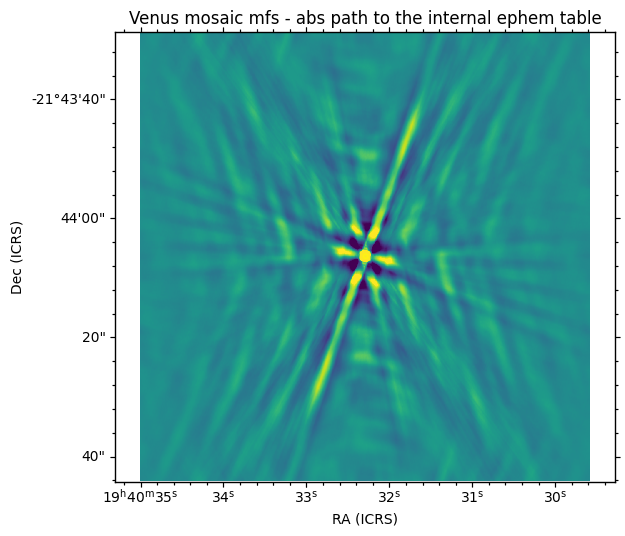

In [14]:
displayImage(imgname+'.image', markers=inephmarker, 
             title='Venus mosaic mfs - abs path to the internal ephem table')

As expected, the center of the image and the position from the internal ephemeris table at the time recorded in the image header agree and the the source appears at the center of the image.

In [15]:
print("internal ephem dir = ",qa.time(ineph_dir['m0'],prec=9),qa.angle(ineph_dir['m1'],prec=9))
printImageCenter(imgname+'.image')

internal ephem dir =  ['19:40:32.285'] ['-021.44.06.359']


('19:40:32.285', '-021.44.06.359')

In [24]:
from casatasks import imstat
stats= imstat(imgname+'.image')
print(f"peak : {stats['max'][0]} at {stats['maxpos'][0]}")

peak : 0.010899072512984276 at 541
